In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from torch.nn import Softplus #smooth relu
import torch.nn as nn
import torch.nn.functional as F
from utils import generate_polynomial_data
import numpy as np
import torch
import torch.optim as optim
from torch.nn import MSELoss, BCELoss
from tqdm import tqdm
import pickle
from model import Net, check_loss_landscape

import matplotlib.pyplot as plt

/afs/csail.mit.edu/u/m/melango/.conda/envs/p3t14/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [3]:
torch.manual_seed(0)
suffix = "1"

n = 20
d = 10000
generate_data = False
usepickle = True

coeffs = -1+2*np.random.rand(d, 1)
xvals = -1+2*np.random.rand(n)
fileend = ".pickle" if usepickle else ".npy"

if generate_data:
    print("Generating Data...")
    X, Y = generate_polynomial_data(coeffs, xvals)
    #make categorical
    inds_pos = np.where(Y>0)
    inds_neg = np.where(Y<=0)
#     print(Y)
    Y[inds_pos] = 1
    Y[inds_neg] = 0
    with open("./datasets/X_categorical_%s%s" %(("pickle_" if usepickle else ""), sufix)+fileend, "wb") as f:
        if usepickle:
            pickle.dump(X, f)
        else:
            np.save(f, X)
    with open("./datasets/Y_categorical_%s%s" %(("pickle_" if usepickle else ""),suffix) + fileend, "wb") as f:
        if usepickle:
            pickle.dump(Y, f)
        else:
            np.save(f, Y)
    with open("./datasets/coeffs_categorical_%s%s" %(("pickle_" if usepickle else ""),suffix) + fileend, "wb") as f:
        if usepickle:
            pickle.dump(coeffs, f)
        else:
            np.save(f, coeffs)
    
else:
    with open("./datasets/X_categorical_%s%s" %(("pickle_" if usepickle else ""),suffix) + fileend, "rb") as f:
        if usepickle:
            X = pickle.load(f)
        else:
            X = np.load(f)
    with open("./datasets/Y_categorical_%s%s" %(("pickle_" if usepickle else ""),suffix) + fileend, "rb") as f:
        if usepickle:
            Y = pickle.load(f)
        else:
            Y = np.load(f)
    with open("./datasets/coeffs_categorical_%s%s" %(("pickle_" if usepickle else ""),suffix) + fileend, "rb") as f:
        if usepickle:
            coeffs = pickle.load(f)
        else:
            coeffs = np.load(f)

In [4]:
#subsample to get 50/50 split
inds_pos = np.where(Y==1)[0]
inds_neg = np.where(Y==0)[0]
pos = np.random.choice(inds_pos, size=int(20/2))
neg = np.random.choice(inds_neg, size=int(20/2))
data_inds = np.concatenate([pos, neg])
data_inds.sort()
X, Y = X[data_inds], Y[data_inds]

  0%|          | 0/50 [00:00<?, ?it/s]

Running on CPU
0.01
epoch: 0\epochLoss =  0.701

  2%|▏         | 1/50 [02:05<1:42:06, 125.04s/it]

epoch: 0\epochLoss =  0.6970.008
epoch: 1\epochLoss =  0.692

  4%|▍         | 2/50 [04:11<1:40:29, 125.61s/it]

epoch: 1\epochLoss =  0.6970.0064
epoch: 2\epochLoss =  0.683

  6%|▌         | 3/50 [06:19<1:38:47, 126.12s/it]

epoch: 2\epochLoss =  0.6980.00512
epoch: 3\epochLoss =  0.722

  8%|▊         | 4/50 [08:23<1:36:14, 125.54s/it]

epoch: 3\epochLoss =  0.7180.004096000000000001
epoch: 4\epochLoss =  0.699

 10%|█         | 5/50 [10:27<1:33:43, 124.97s/it]

epoch: 4\epochLoss =  0.7060.0032768000000000007
epoch: 5\epochLoss =  0.722

 12%|█▏        | 6/50 [12:29<1:31:01, 124.13s/it]

epoch: 5\epochLoss =  0.7250.002621440000000001
epoch: 6\epochLoss =  0.699

 14%|█▍        | 7/50 [14:29<1:28:09, 123.01s/it]

epoch: 6\epochLoss =  0.6950.002097152000000001
epoch: 7\epochLoss =  0.703

 16%|█▌        | 8/50 [16:31<1:25:46, 122.54s/it]

epoch: 7\epochLoss =  0.6820.001677721600000001
epoch: 8\epochLoss =  0.709

 18%|█▊        | 9/50 [18:33<1:23:42, 122.50s/it]

epoch: 8\epochLoss =  0.7100.0013421772800000008
epoch: 9\epochLoss =  0.702

 20%|██        | 10/50 [20:36<1:21:40, 122.52s/it]

epoch: 9\epochLoss =  0.7030.0010737418240000006
epoch: 10\epochLoss =  0.681

 22%|██▏       | 11/50 [22:35<1:19:00, 121.55s/it]

epoch: 10\epochLoss =  0.7020.0008589934592000006
epoch: 11\epochLoss =  0.704

 24%|██▍       | 12/50 [24:35<1:16:42, 121.12s/it]

epoch: 11\epochLoss =  0.6800.0006871947673600005
epoch: 12\epochLoss =  0.690

 26%|██▌       | 13/50 [26:36<1:14:35, 120.96s/it]

epoch: 12\epochLoss =  0.6960.0005497558138880005
epoch: 13\epochLoss =  0.696

 28%|██▊       | 14/50 [28:34<1:12:11, 120.33s/it]

epoch: 13\epochLoss =  0.6900.0004398046511104004
epoch: 14\epochLoss =  0.675

 30%|███       | 15/50 [30:37<1:10:32, 120.92s/it]

epoch: 14\epochLoss =  0.7110.00035184372088832035
epoch: 15\epochLoss =  0.694

 32%|███▏      | 16/50 [32:33<1:07:42, 119.48s/it]

epoch: 15\epochLoss =  0.6940.0002814749767106563
epoch: 16\epochLoss =  0.679

 34%|███▍      | 17/50 [34:25<1:04:32, 117.35s/it]

epoch: 16\epochLoss =  0.7060.00022517998136852504
epoch: 17\epochLoss =  0.690

 36%|███▌      | 18/50 [36:11<1:00:45, 113.93s/it]

epoch: 17\epochLoss =  0.6890.00018014398509482005
epoch: 18\epochLoss =  0.689

 38%|███▊      | 19/50 [38:00<58:03, 112.37s/it]  

0.00014411518807585605
epoch: 19\epochLoss =  0.690

 40%|████      | 20/50 [39:48<55:35, 111.19s/it]

epoch: 19\epochLoss =  0.6950.00011529215046068484
epoch: 20\epochLoss =  0.692

 42%|████▏     | 21/50 [41:39<53:41, 111.08s/it]

epoch: 20\epochLoss =  0.6949.223372036854788e-05
epoch: 21\epochLoss =  0.694

 44%|████▍     | 22/50 [43:28<51:28, 110.31s/it]

epoch: 21\epochLoss =  0.6947.378697629483831e-05
epoch: 22\epochLoss =  0.694

 46%|████▌     | 23/50 [45:19<49:42, 110.46s/it]

epoch: 22\epochLoss =  0.6915.902958103587065e-05
epoch: 23\epochLoss =  0.687

 48%|████▊     | 24/50 [47:08<47:41, 110.05s/it]

epoch: 23\epochLoss =  0.6854.722366482869652e-05
epoch: 24\epochLoss =  0.697

 50%|█████     | 25/50 [48:56<45:36, 109.46s/it]

epoch: 24\epochLoss =  0.6973.777893186295722e-05
epoch: 25\epochLoss =  0.694

 52%|█████▏    | 26/50 [50:44<43:36, 109.03s/it]

epoch: 25\epochLoss =  0.6913.0223145490365776e-05
epoch: 26\epochLoss =  0.690

 54%|█████▍    | 27/50 [52:31<41:33, 108.42s/it]

epoch: 26\epochLoss =  0.6952.4178516392292623e-05
epoch: 27\epochLoss =  0.694

 56%|█████▌    | 28/50 [54:20<39:50, 108.64s/it]

epoch: 27\epochLoss =  0.6941.93428131138341e-05
epoch: 28\epochLoss =  0.693

 58%|█████▊    | 29/50 [56:12<38:26, 109.83s/it]

epoch: 28\epochLoss =  0.6921.547425049106728e-05
epoch: 29\epochLoss =  0.693

 60%|██████    | 30/50 [57:57<36:07, 108.36s/it]

epoch: 29\epochLoss =  0.6931.2379400392853824e-05
epoch: 30\epochLoss =  0.693

 62%|██████▏   | 31/50 [59:48<34:33, 109.12s/it]

epoch: 30\epochLoss =  0.6939.90352031428306e-06
epoch: 31\epochLoss =  0.693

 64%|██████▍   | 32/50 [1:01:37<32:43, 109.06s/it]

epoch: 31\epochLoss =  0.6937.922816251426448e-06
epoch: 32\epochLoss =  0.690

 66%|██████▌   | 33/50 [1:03:28<31:04, 109.65s/it]

epoch: 32\epochLoss =  0.6936.338253001141159e-06
epoch: 33\epochLoss =  0.693

 68%|██████▊   | 34/50 [1:05:19<29:18, 109.88s/it]

epoch: 33\epochLoss =  0.6935.0706024009129275e-06
epoch: 34\epochLoss =  0.690

 70%|███████   | 35/50 [1:07:06<27:17, 109.17s/it]

epoch: 34\epochLoss =  0.6924.056481920730342e-06
epoch: 35\epochLoss =  0.692

 72%|███████▏  | 36/50 [1:08:55<25:28, 109.21s/it]

epoch: 35\epochLoss =  0.6933.245185536584274e-06
epoch: 36\epochLoss =  0.693

 74%|███████▍  | 37/50 [1:10:44<23:37, 109.00s/it]

epoch: 36\epochLoss =  0.6932.596148429267419e-06
epoch: 37\epochLoss =  0.693

 76%|███████▌  | 38/50 [1:12:33<21:46, 108.86s/it]

epoch: 37\epochLoss =  0.6932.0769187434139356e-06
epoch: 38\epochLoss =  0.693

 78%|███████▊  | 39/50 [1:14:20<19:51, 108.30s/it]

epoch: 38\epochLoss =  0.6931.6615349947311485e-06
epoch: 39\epochLoss =  0.693

 80%|████████  | 40/50 [1:16:05<17:54, 107.48s/it]

epoch: 39\epochLoss =  0.6931.3292279957849189e-06
epoch: 40\epochLoss =  0.693

 82%|████████▏ | 41/50 [1:17:55<16:13, 108.17s/it]

epoch: 40\epochLoss =  0.6931.0633823966279351e-06
epoch: 41\epochLoss =  0.693

 84%|████████▍ | 42/50 [1:19:44<14:27, 108.46s/it]

epoch: 41\epochLoss =  0.6928.507059173023481e-07
epoch: 42\epochLoss =  0.693

 86%|████████▌ | 43/50 [1:21:31<12:35, 107.98s/it]

epoch: 42\epochLoss =  0.6936.805647338418785e-07
epoch: 43\epochLoss =  0.693

 88%|████████▊ | 44/50 [1:23:18<10:46, 107.78s/it]

epoch: 43\epochLoss =  0.6935.444517870735028e-07
epoch: 44\epochLoss =  0.693

 90%|█████████ | 45/50 [1:25:05<08:57, 107.59s/it]

epoch: 44\epochLoss =  0.6934.355614296588023e-07
epoch: 45\epochLoss =  0.692

 92%|█████████▏| 46/50 [1:26:54<07:11, 107.97s/it]

epoch: 45\epochLoss =  0.6933.484491437270418e-07
epoch: 46\epochLoss =  0.693

 94%|█████████▍| 47/50 [1:28:42<05:23, 107.79s/it]

epoch: 46\epochLoss =  0.6932.7875931498163346e-07
epoch: 47\epochLoss =  0.693

 96%|█████████▌| 48/50 [1:30:29<03:35, 107.68s/it]

epoch: 47\epochLoss =  0.6932.230074519853068e-07
epoch: 48\epochLoss =  0.693

 98%|█████████▊| 49/50 [1:32:25<01:50, 110.19s/it]

epoch: 48\epochLoss =  0.6931.7840596158824544e-07
epoch: 49\epochLoss =  0.693

100%|██████████| 50/50 [1:34:28<00:00, 113.36s/it]

epoch: 49\epochLoss =  0.693

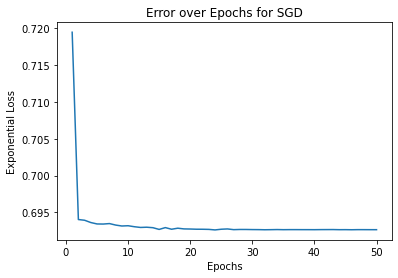

In [6]:
torch.manual_seed(0)

sgd = True
train = True

if sgd:
    model_path = "./models/model_sgd_categorical_%s.pt"%suffix
    net = Net(d, epochs = 50, loss = BCELoss(reduction="sum"), categorical = True)
else:
    model_path = "./models/model_categorical_%s.pt"%suffix
    net = Net(d, epochs = 20, loss = BCELoss(reduction="sum"), categorical = True)
    
if train:
    usegpu=False
    if torch.cuda.is_available() and usegpu:
        device = torch.device("cuda:0")
        print("Running on GPU")
    else:
        device = torch.device("cpu")
    net.to(device)
    if sgd:
        net.train_sgd(X, Y, 10000, lr = 1e-2, usegpu = usegpu)
    else:
        net.train_gd(X, Y, 2000, lr = 1e-3, usegpu = usegpu)
    torch.save(net.state_dict(), model_path)

Overall loss: tensor(0.4984, grad_fn=<MseLossBackward>)


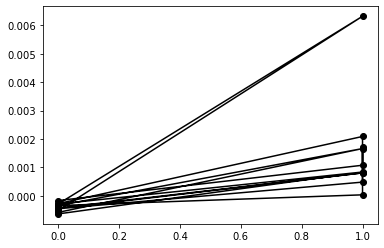

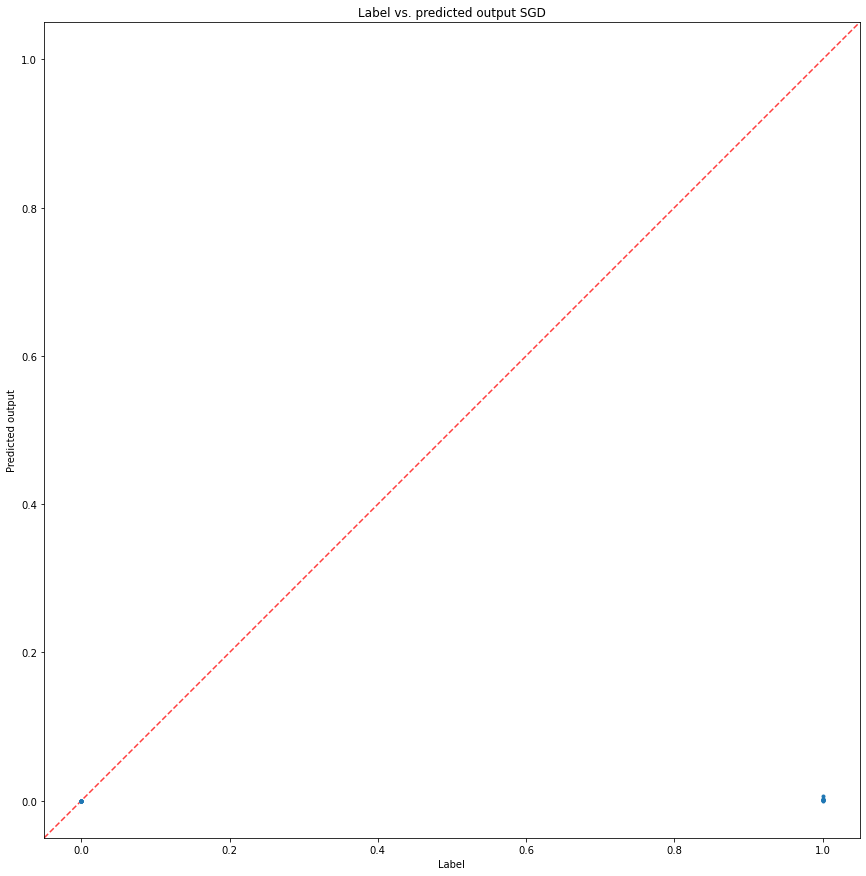

In [7]:
check_loss_landscape(model_path, X, Y, sgd=True)